In [1]:
# importing required packages
import numpy as np
from matplotlib import pyplot as plt

# Full order model

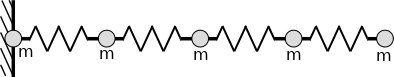

This time the system has mass, therefore there will be time-dependence -> Not static anymore.

We simulate the system without any external force, but with an initial displacement (based on a static simulation with a given force).

The classes for Domain and ReferenceElement are the same as in the Static case

In [2]:
class Domain():
    #1D domain class
    def __init__(self, number_of_elements):
        self.number_of_elements = number_of_elements
        self.number_of_nodes = self.number_of_elements+1
        self.nodes_coordinates = np.linspace(0,1,self.number_of_nodes)
        self.connectivity = np.c_[np.linspace(0,self.number_of_nodes-2,self.number_of_nodes-1), np.linspace(1,self.number_of_nodes-1,self.number_of_nodes-1) ]

In [3]:
class ReferenceElement():
    def __init__(self):
        self.degree = 1
        self.reference_domain = np.array([-1,1])
        self.number_nodes = 2
        self.number_gauss_points = 2
        self.gauss_points_locations = np.array([-1/np.sqrt(3) , 1/np.sqrt(3)])
        self.gauss_points_weights = np.array([1,1])
        self.shape_functions_at_gauss_points =  np.array([(1-self.gauss_points_locations)/2  , (1+self.gauss_points_locations)/2])
        self.shape_functions_derivatives_at_gauss_points  =  np.array ([[-0.5, 0.5 ],[-0.5, 0.5]])
        self.shape_functions_second_derivatives_at_gauss_points = np.array ([[0, 0 ],[0, 0]])

In [4]:
class FOM_simulation(object):

    def __init__( self, number_of_elements=5, total_time=20, time_step_size=.1):
        self.total_time = total_time
        self.number_of_time_steps =int(total_time/time_step_size)
        self.time_step_size = time_step_size
        self.domain = Domain(number_of_elements)
        self.reference_element = ReferenceElement()

    def Run(self):
        self.ComputeSystemMatrix()
        self.Solve()

    def ComputeSystemMatrix(self):
        self.K = np.zeros((self.domain.number_of_nodes, self.domain.number_of_nodes))
        self.M = self.K.copy()
        #element loop
        for ith_element in range(self.domain.number_of_elements):
            element_connectivity = self.domain.connectivity[ith_element, :]
            element_coordinates = self.domain.nodes_coordinates[element_connectivity.astype(int)]
            element_length =  element_coordinates[-1] - element_coordinates[0]
            K_element = np.zeros((self.reference_element.number_nodes,self.reference_element.number_nodes))
            M_element = K_element.copy()
            #gauss points loop
            for i in range(self.reference_element.number_gauss_points):
                shape_function_i = self.reference_element.shape_functions_at_gauss_points[i,:]
                shape_function_derivative_i = self.reference_element.shape_functions_derivatives_at_gauss_points[i,:] * 2/element_length
                weight_i = self.reference_element.gauss_points_weights[i] * element_length/2
                K_element += weight_i * (shape_function_derivative_i.reshape(-1,1) @ shape_function_derivative_i.reshape(1,-1))
                M_element += weight_i * (shape_function_i.reshape(-1,1) @ shape_function_i.reshape(1,-1))
            #assembly
            for e_i, i in zip([0,1], element_connectivity.astype(int)):
                for e_j, j in zip([0,1],element_connectivity.astype(int)):
                    self.M[i,j] +=  M_element[e_i,e_j]
                    self.K[i,j] +=  K_element[e_i,e_j]

        plt.spy(self.K)
        plt.title(f'Matrix K sparsity pattern', fontsize=15, fontweight='bold')
        plt.figure()
        plt.spy(self.M)
        plt.title(f'Matrix M sparsity pattern', fontsize=15, fontweight='bold')
        plt.show()


    def GetInitialDisplacement(self, applied_force):
        # We solve the static case for the given force and get the resulting
        # displacements to use as the inital condition for the dynamic case
        applied_force_vector = np.zeros((self.domain.number_of_elements))
        applied_force_vector[-1] = applied_force
        Displacement_init = np.zeros((self.domain.number_of_nodes))
        Displacement_init[1:] = np.squeeze(np.linalg.solve(self.K[1:,1:], applied_force_vector))

        return Displacement_init


    def Solve(self):
        self.set_up_Newmark_coefficients()

        applied_force = 1
        Displacement_old = self.GetInitialDisplacement(applied_force) #solve static problem to determine original deformation state

        Displacement_new = Displacement_old.copy() # The time integration routine requires the displacements of two consecutive timesteps, which we initialize to the same value
                                                   # Mind that the .copy() is essential for numpy matrices, otherwise updating Displacement_new would also update Displacement_old and viceversa
        Velocity_old = np.zeros((self.domain.number_of_nodes))
        Acceleration_old = np.zeros((self.domain.number_of_nodes))

        self.SnapshotsMatrixDisplacements = np.zeros((np.shape(Displacement_old)[0],self.number_of_time_steps))
        self.SnapshotsMatrixDisplacements[:,0] = Displacement_old
        self.SnapshotsMatrixVelocities = np.zeros((np.shape(Displacement_old)[0],self.number_of_time_steps))
        self.SnapshotsMatrixVelocities[:,0] = Velocity_old
        self.SnapshotsMatrixAccelerations = np.zeros((np.shape(Displacement_old)[0],self.number_of_time_steps))
        self.SnapshotsMatrixAccelerations[:,0] = Acceleration_old

        F = np.zeros((self.domain.number_of_nodes))
        K_hat = self.K + self.a0*self.M

        for i in range(1,self.number_of_time_steps):
            F_hat = F + self.M @ (self.a0*Displacement_old  +  self.a2*Velocity_old   + self.a3 * Acceleration_old)

            #solve system for displacement
            Displacement_new[1:] = np.linalg.solve(K_hat[1:,1:], F_hat[1:])

            #update acceleration using Newmark coefficients
            Acceleration_new = self.a0 * (Displacement_new - Displacement_old)  - self.a2*Velocity_old -  self.a3 * Acceleration_old

            #update velocity using Newmark coefficients
            Velocity_new = Velocity_old + self.a6 * Acceleration_old + self.a7*Acceleration_new

            self.SnapshotsMatrixDisplacements[:,i] = Displacement_new
            self.SnapshotsMatrixVelocities[:,i] = Velocity_new
            self.SnapshotsMatrixAccelerations[:,i] = Acceleration_new

            #reset_variables
            Displacement_old = Displacement_new.copy()
            Velocity_old = Velocity_new.copy()
            Acceleration_old = Acceleration_new.copy()


    def set_up_Newmark_coefficients(self, alpha=0.25, beta=0.5):
        dt = self.time_step_size
        self.a0=1/(alpha*(dt**2))
        self.a1=beta/(alpha*dt)
        self.a2=1/(alpha*dt)
        self.a3=(1/(2*alpha))-1
        self.a4=(beta/alpha)-1
        self.a5=(dt/2)*((beta/alpha)-2)
        self.a6=dt*(1-beta)
        self.a7=beta*dt

In [5]:
#Launching the FOM simulation

number_of_elements = 5
total_time = 4
time_step_size = 0.1

fom_simulation = FOM_simulation(number_of_elements, total_time, time_step_size) # Instantiates a simulator with the specified domain

print('FOM simulation with ', fom_simulation.domain.number_of_elements, ' elements')
print('FOM simulation with ',fom_simulation.number_of_time_steps, ' time steps')

FOM simulation with  5  elements
FOM simulation with  40  time steps


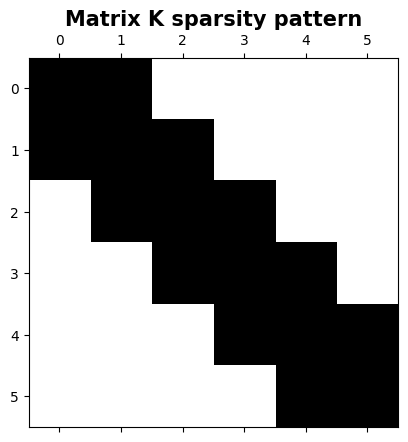

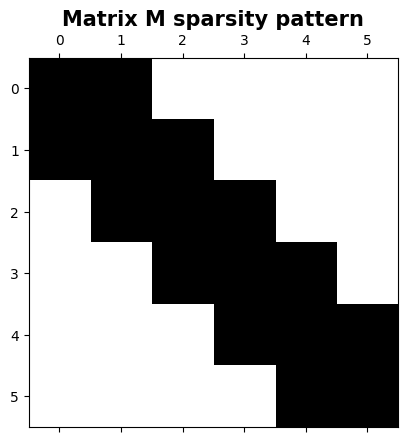

In [6]:
#Running the Simulation
fom_simulation.Run()  # creates the system matrix K and solves the system for each of the load steps

In [7]:
def plot_a_displacement_FOM(fom_simulation, snapshot_to_print):
    snapshots = fom_simulation.SnapshotsMatrixDisplacements
    times = np.linspace(0, fom_simulation.total_time, fom_simulation.number_of_time_steps+1)[:-1]
    number_of_nodes = np.shape(snapshots)[0]

    snapshot = snapshots[:,snapshot_to_print]
    plt.plot(np.linspace(0,number_of_nodes,number_of_nodes), snapshot, 'b-o',alpha=0.5,label=f't={times[snapshot_to_print]:.1f}')
    plt.title(f'FOM Simulation Result for step {snapshot_to_print}', fontsize=15, fontweight='bold')
    plt.legend()
    plt.ylabel('displacement')
    plt.xlabel('node')
    plt.show()

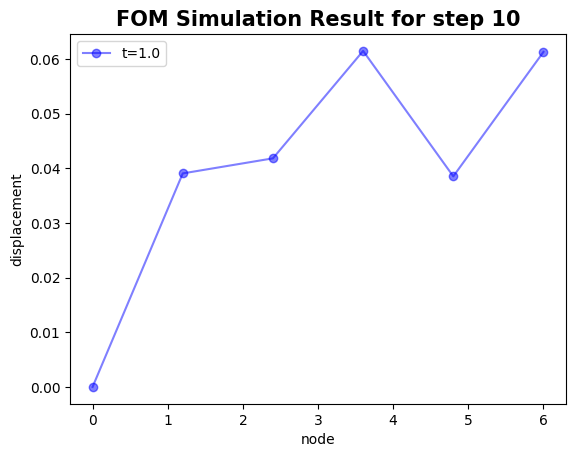

In [8]:
# Visualize the results (one at a time)
step_to_display = 10
plot_a_displacement_FOM(fom_simulation, step_to_display)

# Modal Analysis

### Solve the generalized eigenvalue problem $K \phi = \lambda M \phi$ using the scipy library's function $\textit{eigh}$


In [9]:
from scipy.linalg import eigh

def compute_modal_analysis_basis(K, M):
    # Task 3 
    _, basis = eigh(K[1:, 1:], M[1:, 1:]) 

    
    basis = np.vstack((np.zeros(basis.shape[1]), basis))
    return basis

In [10]:
# Compute basis and print its shape
basis = compute_modal_analysis_basis(fom_simulation.K, fom_simulation.M)
print('Basis shape: ', basis.shape)

Basis shape:  (6, 5)


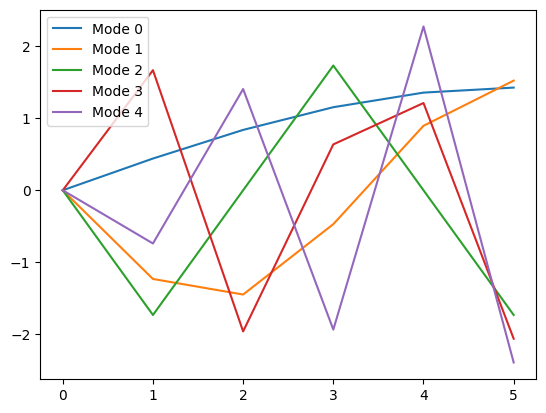

In [11]:
# Let's visualize the modes
for i, mode in enumerate(basis.T):
  plt.plot(mode, label=f'Mode {i}')
plt.legend()
plt.show()

In [12]:
class ROM_simulation(FOM_simulation):

    def __init__(self, number_of_elements,total_time,time_step_size,basis):
        super().__init__(number_of_elements, total_time, time_step_size)
        self.basis = basis

    def ComputeSystemMatrix(self):
        self.K = np.zeros((np.shape(self.basis)[1], np.shape(self.basis)[1]))
        self.M = self.K.copy()

        ########################################
        # Task 4
        # YOUR CODE HERE   (1 point)

        #element loop
        for ith_element in range(self.domain.number_of_elements):
            element_connectivity = self.domain.connectivity[ith_element, :]
            element_coordinates = self.domain.nodes_coordinates[element_connectivity.astype(int)]
            element_length =  element_coordinates[-1] - element_coordinates[0]
            K_element = np.zeros((self.reference_element.number_nodes,self.reference_element.number_nodes))
            M_element = K_element.copy()
            element_basis = self.basis[element_connectivity.astype(int), :]

            #gauss points loop
            for i in range(self.reference_element.number_gauss_points):
                shape_function_i = self.reference_element.shape_functions_at_gauss_points[i,:]
                shape_function_derivative_i = self.reference_element.shape_functions_derivatives_at_gauss_points[i,:] * 2/element_length
                weight_i = self.reference_element.gauss_points_weights[i] * element_length/2
                K_element += weight_i * (shape_function_derivative_i.reshape(-1,1) @ shape_function_derivative_i.reshape(1,-1))
                M_element += weight_i * (shape_function_i.reshape(-1,1) @ shape_function_i.reshape(1,-1))
            #assembly
            self.K +=  element_basis.T @ K_element @ element_basis
            self.M +=  element_basis.T @ M_element @ element_basis

        ########################################


    def GetInitialDisplacement(self, applied_force):
        # This method solves a static problem to get the initial displacement at all nodes.
        applied_foce_vector = np.zeros((self.domain.number_of_nodes))
        applied_foce_vector[-1] = applied_force
        applied_foce_vector_rom = self.basis.T @ applied_foce_vector
        Displacement_old_rom = np.squeeze(np.linalg.solve(self.K , applied_foce_vector_rom))
        return Displacement_old_rom


    def Solve(self):
        self.set_up_Newmark_coefficients()

        applied_force = 1
        Displacement_old_rom = self.GetInitialDisplacement(applied_force) #solve static problem to determine original deformation state

        Displacement_new_rom = Displacement_old_rom.copy()
        Velocity_old_rom = np.zeros((np.shape(self.basis)[1]))
        Acceleration_old_rom = np.zeros((np.shape(self.basis)[1]))

        self.SnapshotsMatrixDisplacements_rom = np.zeros((np.shape(self.basis)[1],self.number_of_time_steps))
        self.SnapshotsMatrixDisplacements_rom[:,0] = Displacement_old_rom
        self.SnapshotsMatrixVelocities_rom = np.zeros((np.shape(self.basis)[1],self.number_of_time_steps))
        self.SnapshotsMatrixVelocities_rom[:,0] = Velocity_old_rom
        self.SnapshotsMatrixAccelerations_rom = np.zeros((np.shape(self.basis)[1],self.number_of_time_steps))
        self.SnapshotsMatrixAccelerations_rom[:,0] = Acceleration_old_rom

        F = np.zeros((np.shape(self.basis)[1]))
        K_hat = self.K + self.a0*self.M

        for i in range(1,self.number_of_time_steps):
            F_hat = F + self.M @ (self.a0*Displacement_old_rom  +  self.a2*Velocity_old_rom  + self.a3 * Acceleration_old_rom)

            #solve system for displacement
            Displacement_new_rom  = np.linalg.solve(K_hat, F_hat)

            #update acceleration using Newmark coefficients
            Acceleration_new_rom = self.a0 * (Displacement_new_rom - Displacement_old_rom)  - self.a2*Velocity_old_rom -  self.a3 * Acceleration_old_rom

            #update velocity using Newmark coefficients
            Velocity_new_rom = Velocity_old_rom + self.a6 * Acceleration_old_rom + self.a7*Acceleration_new_rom

            self.SnapshotsMatrixDisplacements_rom[:,i] = Displacement_new_rom
            self.SnapshotsMatrixVelocities_rom[:,i] = Velocity_new_rom
            self.SnapshotsMatrixAccelerations_rom[:,i] = Acceleration_new_rom

            #reset_variables
            Displacement_old_rom = Displacement_new_rom.copy()
            Velocity_old_rom = Velocity_new_rom.copy()
            Acceleration_old_rom = Acceleration_new_rom.copy()


In [13]:
# Run the ROM simulation with the same parameters as the FOM, plus a basis (modal analysis)
n = 2
truncated_basis = basis[:,:n] # We only use the first n modes
rom_simulation = ROM_simulation(number_of_elements,total_time,time_step_size,truncated_basis)
rom_simulation.Run()

In [14]:
# Compare the results (one at a time)

def plot_a_snapshot(fom_simulation, rom_simulation, snapshot_to_print):

  snapshots_FOM = fom_simulation.SnapshotsMatrixDisplacements
  snapshots_ROM = rom_simulation.basis @ rom_simulation.SnapshotsMatrixDisplacements_rom

  # You can ignore this. It just checks that FOM and ROM have been run with the same parameters
  incompatibility = snapshots_FOM.shape[0] != snapshots_ROM.shape[0]
  incompatibility += fom_simulation.number_of_time_steps != rom_simulation.number_of_time_steps
  incompatibility += fom_simulation.time_step_size != rom_simulation.time_step_size
  if incompatibility:
    raise Exception('Please make sure to run both FOM and ROM with the same parameters')

  snapshot_i_FOM = snapshots_FOM[:,snapshot_to_print]
  snapshot_i_ROM = snapshots_ROM[:,snapshot_to_print]
  number_of_nodes = np.shape(snapshot_i_FOM)[0]

  x_axis = np.linspace(0,number_of_nodes,number_of_nodes)
  plt.plot(x_axis, snapshot_i_FOM, 'b-o',alpha=0.5,label='FOM')
  plt.plot(x_axis, snapshot_i_ROM,'ro',label='ROM')
  plt.ylabel('displacement')
  plt.xlabel('node')
  plt.title(f'FOM vs ROM Simulation Results', fontsize=15, fontweight='bold')
  plt.legend()

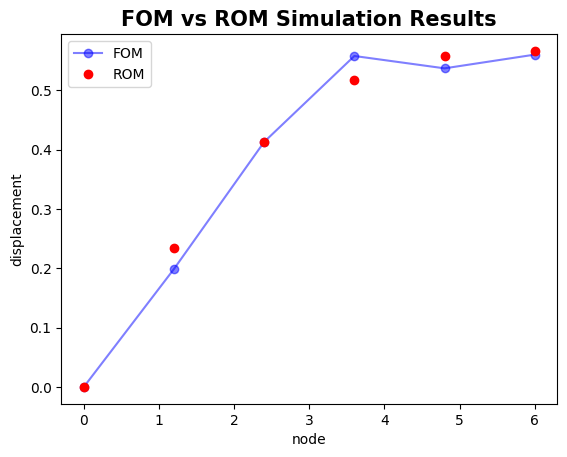

In [15]:
snapshot_to_print = 5
plot_a_snapshot(fom_simulation, rom_simulation, snapshot_to_print)

In [16]:
#compute the approximation error
snapshots_FOM = fom_simulation.SnapshotsMatrixDisplacements
snapshots_ROM = rom_simulation.basis @ rom_simulation.SnapshotsMatrixDisplacements_rom
print('approximation error: ', 100* np.linalg.norm(snapshots_FOM - snapshots_ROM)/ np.linalg.norm(snapshots_FOM), ' %' )

approximation error:  5.6842537205294255  %


# Proper Orthogonal Decomposition

For POD, we need to first find a proper basis via SVD. But we are not taking all the modes that the SVD gives us, instead we are truncating at a certain amount of modes $k$.

The truncation tolerance should be based on the relative error that we want of the truncated snapshot matrix versus the original one. And we will determine it via the singular values. See:

$ X \in \mathbb{R}^{n\times m}$, $X = U\Sigma V^T$ , $\Sigma = diag(\sigma_1,\sigma_2, ..., \sigma_m )$

And $X_k\in \mathbb{R}^{n\times m}$, $X_k = U_k\Sigma_k V_k^T=U_kU_k^TX$

We know that $||X||_F=\sqrt{\sum_{i=1}^m\sigma_i^2}$ and $||X-X_k||_F=\sqrt{\sum_{i=k+1}^m\sigma_i^2}$.

Therefore, we know the relative error for a certain truncation based on the singular values alone, and we can find $k$ such that:

$ \frac{||X-X_k||_F}{||{X}||_F} = \sqrt{\frac{\sum_{i=k+1}^m \sigma_i^2}{\sum_{i=1}^m \sigma_i^2}} \leq \epsilon $

Where $\epsilon$ is the relative error we want to achieve in our approximation.

In [26]:
# Complete the function that computes the POD basis using the SVD (truncate the obtained basis using the Frobenius Norm)

def compute_basis(SnapshotsMatrix, truncation_tolerance=1e-4):

    #take the svd ignoring fixed dof and plot the singular values
    u,s,v = np.linalg.svd(SnapshotsMatrix[1:,:],full_matrices=False)
    plt.plot(s, 'bo-')
    plt.yscale('log')
    plt.title(f'Singular Values', fontsize=15, fontweight='bold')
    plt.show()

    ########################################
    #YOUR CODE HERE
    # Task 5 (1 point) Add modes to matrix Phi until the given tolerance is achieved

    cumulative_energy = np.cumsum(s**2) / np.sum(s**2)  
    num_modes = np.searchsorted(cumulative_energy, 1 - truncation_tolerance) + 1

    Phi = u[:, :num_modes]

    ########################################

    return np.r_[np.zeros((1,Phi.shape[1])), Phi] #return adding ignored dofs


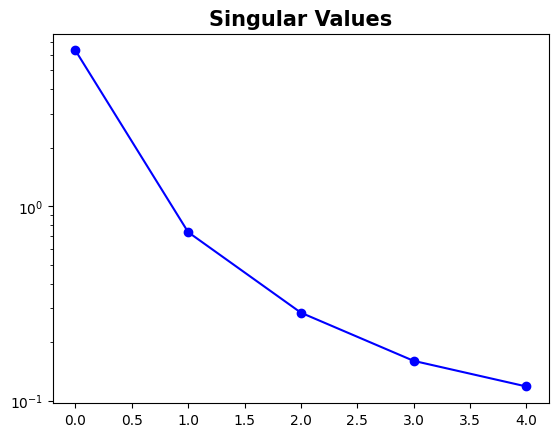



The shape of the snapshot matrix is:  (6, 40)
The basis shape is:  (6, 3) 




In [42]:
# Call your function and obtain a basis from the FOM simulation snapshots

#tolerance = 0.2
#tolerance = 0.1
tolerance = 1e-3

basis = compute_basis(fom_simulation.SnapshotsMatrixDisplacements, tolerance)
print('\n\nThe shape of the snapshot matrix is: ', fom_simulation.SnapshotsMatrixDisplacements.shape)
print('The basis shape is: ', basis.shape, '\n\n')

In [43]:
# Here we manually check the relative error of the reconstruction
# It should always be lower than the tolerance we specified
fom_snapshot_matr = fom_simulation.SnapshotsMatrixDisplacements
projected_snapshot_matr = basis.T @ fom_snapshot_matr
reconstructed_snapshot_matr = basis @ projected_snapshot_matr
print('Reconstruction relative error: ', np.linalg.norm(fom_snapshot_matr-reconstructed_snapshot_matr)/np.linalg.norm(fom_snapshot_matr)*100,'%')

Reconstruction relative error:  3.124047187183642 %


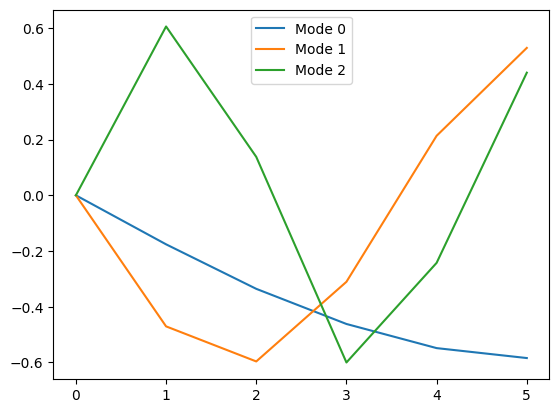

In [44]:
# Let's visualize the modes
for i, mode in enumerate(basis.T):
  plt.plot(mode, label=f'Mode {i}')
plt.legend()
plt.show()

In [45]:
# Create the ROM simulation with the same parameters as the FOM, plus a basis (POD)
rom_simulation = ROM_simulation(number_of_elements,total_time, time_step_size, basis)
rom_simulation.Run()

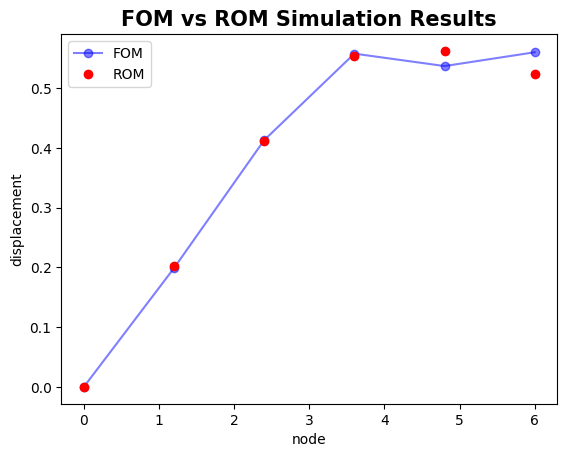

In [46]:
# plotting a comparison of the results

snapshot_to_print = 5
plot_a_snapshot(fom_simulation, rom_simulation, snapshot_to_print)

In [47]:
#compute the approximation error
snapshots_FOM = fom_simulation.SnapshotsMatrixDisplacements
snapshots_ROM = rom_simulation.basis @ rom_simulation.SnapshotsMatrixDisplacements_rom
print('approximation error: ', 100* np.linalg.norm(snapshots_FOM - snapshots_ROM)/ np.linalg.norm(snapshots_FOM), ' %' )

approximation error:  3.5476097977916874  %


In [ ]:
## Task 6. (1 point)
# Draw the workflow of the dynamic problem
